# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb


from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


# magic word for producing visualizations in notebook
%matplotlib inline

# For displaying max number of lines
pd.set_option("display.max_rows", 500)

# For reproducability
SEED = 2

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [31]:
def load_avarto_data(clean = False, scaled = False):
    """
    Loads azdias, customer, attribute values and attribute information data
    
    Args:
        clean (bool): loads cleaned data, if set to True and cleaned data exists.
                Default: False
    
    Returns:
        azdias : Azdias DataFrame
        customers : Customers DataFrame
        attribute_values : Attribute values DataFrame
        attribute_info : Attribute information DataFrame
        
    """
    
    # Ignore any empty columns while loading data
    no_unamed = lambda x: 'Unnamed' not in x
    
    # Check if cleaned data exists
    clean_exists = False
    if clean:
        clean_exists = os.path.isfile("./data/Customers_cleaned.csv") & \
            os.path.isfile("./data/Azdias_cleaned.csv")
        if clean_exists:
            print("Cleaned Data Exists")
        else:
            print("Cleaned Data does not Exist!")
            
    # Check if scaled data exists
    scaled_exists = False
    if scaled:
        scaled_exists = clean_exists = os.path.isfile("./data/Customers_scaled.csv") & \
            os.path.isfile("./data/Azdias_scaled.csv")
        if scaled_exists:
            print("Scaled Data Exists")
        else:
            print("Scaled Data does not Exist!")
                
        
#     azdias = None
#     customers = None
    customers_additional = None
#     attributes_values = None
#     attributes_info = None

    if scaled and scaled_exists:
        print("Loading Scaled Azdias and Customers Data")
        azdias = pd.read_csv('./data/Azdias_scaled.csv', usecols=no_unamed)
        customers = pd.read_csv('./data/Customers_scaled.csv', usecols=no_unamed)
        customers_additional = pd.read_csv('./data/Customer_Additional_cleaned.csv', usecols=no_unamed)

    else:
        if clean_exists:
            print("Loading Cleaned Azdias and Customers Data")
            azdias = pd.read_csv('./data/Azdias_cleaned.csv', usecols=no_unamed)
            customers = pd.read_csv('./data/Customers_cleaned.csv', usecols=no_unamed)
            customers_additional = pd.read_csv('./data/Customer_Additional_cleaned.csv', usecols=no_unamed)
        else:
            print("Loading Raw Azdias and Customers Data")
            azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', usecols=no_unamed)
            customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', usecols=no_unamed)

    attributes_values = pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
    attributes_info = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)    
    
    return azdias, customers, customers_additional, attributes_values, attributes_info

In [32]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias, customers, customers_additional, attributes_values, attributes_info = load_avarto_data()

Loading Raw Azdias and Customers Data


D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


The warning says columns 18 and 19 have mixed data types, we can explore these two columns in later steps. This is one point to remember.

## 0.1 Data Preprocessing

### 0.1.1 Verifying integrity
Checking data shapes:

Verifying whether shapes of dataframes and the extra columns that are there in the customers dataset as per the description.

In [33]:
print("Azdias shape -",azdias.shape)
print("Customers shape -",customers.shape)

Azdias shape - (891221, 366)
Customers shape - (191652, 369)


In [34]:
print("Number of columns in Customers Data - ", len(list(customers.columns)))
print("Number of columns in Azdius Data - ", len(list(azdias.columns)))

extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

Number of columns in Customers Data -  369
Number of columns in Azdius Data -  366
Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


check heads of the dataset:

In [18]:
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0                 11.0  ...   
2          NaN          NaN                  17.0                 10.0  ...   
3          NaN          NaN                  13.0                  1.0  ...   
4          NaN          NaN                  14.0                  3.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  NaN       NaN         NaN      NaN             NaN             NaN   
1  4.0       8.0        11.0     10.0             3.0             9.0   
2  2.0       9.0         9.0      6.0             3.0             9.0   
3  0.0       7.0        10.0     11.0             NaN             9.0   
4  2.0       3.0         5.0      4.0             2.0             9.0   

   WOHNLAGE ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  
0       NaN        3          1                     2  
1       4.0        5          2                     1  
2       2.0        5          2                     3  
3       7.0        3          2                     4  
4       3.0        4          1                     3  

[5 rows x 366 columns]

In [19]:
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                  10.0                  1.0  ...   
1          NaN          NaN                   NaN                  NaN  ...   
2          NaN          NaN                   0.0                  1.0  ...   
3          NaN          NaN                   8.0                  0.0  ...   
4          NaN          NaN                  14.0                  7.0  ...   

   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  \
0      2.0             6.0             9.0       7.0         3   
1      3.0             0.0             9.0       NaN         3   
2     11.0             6.0             9.0       2.0         3   
3      2.0             NaN             9.0       7.0         1   
4      4.0             2.0             9.0       3.0         1   

       PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE  ANREDE_KZ  \
0  COSMETIC_AND_FOOD     MULTI_BUYER               0          1   
1               FOOD    SINGLE_BUYER               0          1   
2  COSMETIC_AND_FOOD     MULTI_BUYER               0          2   
3           COSMETIC     MULTI_BUYER               0          1   
4               FOOD     MULTI_BUYER               0          1   

   ALTERSKATEGORIE_GROB  
0                     4  
1                     4  
2                     4  
3                     4  
4                     3  

[5 rows x 369 columns]

From the above results, we can see lots of NaN values in the dataset, and this is something that needs to be handled later. We can also check the extra columns again.

In [20]:
customers[extra_cols_in_customers].head()

PRODUCT_GROUP CUSTOMER_GROUP  ONLINE_PURCHASE
0  COSMETIC_AND_FOOD    MULTI_BUYER                0
1               FOOD   SINGLE_BUYER                0
2  COSMETIC_AND_FOOD    MULTI_BUYER                0
3           COSMETIC    MULTI_BUYER                0
4               FOOD    MULTI_BUYER                0

In [21]:
attributes_values.head()

Attribute         Description Value                     Meaning
0  AGER_TYP  best-ager typology    -1                     unknown
1  AGER_TYP                 NaN     0  no classification possible
2  AGER_TYP                 NaN     1             passive elderly
3  AGER_TYP                 NaN     2            cultural elderly
4  AGER_TYP                 NaN     3   experience-driven elderly

In [22]:
attributes_info.head()

Information level             Attribute  \
0               NaN              AGER_TYP   
1            Person  ALTERSKATEGORIE_GROB   
2               NaN             ANREDE_KZ   
3               NaN         CJT_GESAMTTYP   
4               NaN     FINANZ_MINIMALIST   

                                         Description  \
0                                 best-ager typology   
1                      age through prename analysis    
2                                             gender   
3  Customer-Journey-Typology relating to the pref...   
4         financial typology: low financial interest   

                                    Additional notes  
0  in cooperation with Kantar TNS; the informatio...  
1  modelled on millions of first name-age-referen...  
2                                                NaN  
3  relating to the preferred information, marketi...  
4  Gfk-Typology based on a representative househo...

In [35]:
# fill the nan values in Attribute column 
# to access all the information 
# regarding an attribute in one go
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values.head(15)

Attribute                                   Description  Value  \
0               AGER_TYP                            best-ager typology     -1   
1               AGER_TYP                                           NaN      0   
2               AGER_TYP                                           NaN      1   
3               AGER_TYP                                           NaN      2   
4               AGER_TYP                                           NaN      3   
5   ALTERSKATEGORIE_GROB  age classification through prename analysis   -1, 0   
6   ALTERSKATEGORIE_GROB                                           NaN      1   
7   ALTERSKATEGORIE_GROB                                           NaN      2   
8   ALTERSKATEGORIE_GROB                                           NaN      3   
9   ALTERSKATEGORIE_GROB                                           NaN      4   
10  ALTERSKATEGORIE_GROB                                           NaN      9   
11              ALTER_HH                 main age within the household      0   
12              ALTER_HH                                           NaN      1   
13              ALTER_HH                                           NaN      2   
14              ALTER_HH                                           NaN      3   

                             Meaning  
0                            unknown  
1         no classification possible  
2                    passive elderly  
3                   cultural elderly  
4          experience-driven elderly  
5                            unknown  
6                         < 30 years  
7                      30 - 45 years  
8                      46 - 60 years  
9                         > 60 years  
10             uniformly distributed  
11  unknown / no main age detectable  
12         01.01.1895 bis 31.12.1899  
13         01.01.1900 bis 31.12.1904  
14         01.01.1905 bis 31.12.1909

In [36]:
print(azdias.columns[18:20])
warning_cols = list(azdias.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [37]:
azdias[warning_cols[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [38]:
azdias[warning_cols[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [39]:
customers[warning_cols[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [40]:
customers[warning_cols[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

We have 'X' and 'XX' as values in these columns which have not been given in the description. These values can be replaced with 'np.nan', as in the attributes dataframe it is described that any unknown values can be treated as '-1' but for simpicity we can consider this '-1' as 'np.nan'. Also there is inconsistency in the values, i.e. some of them are strings and some of them are floats. We can to convert all of them into integers.

In [41]:
# replace abnormal value in dataset
def fix_cameo_cols(df):
    """Function to replace 'X', 'XX' with nan
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    return df

In [42]:
customers = fix_cameo_cols(customers)
azdias = fix_cameo_cols(azdias)
azdias[warning_cols[1]].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [43]:
customers[warning_cols[1]].unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

### 0.1.2 Attribute Values

In [44]:
# drop nan
attributes_values.dropna()

Attribute  \
0                        AGER_TYP   
5            ALTERSKATEGORIE_GROB   
11                       ALTER_HH   
33                      ANREDE_KZ   
36            ANZ_HAUSHALTE_AKTIV   
37                   ANZ_HH_TITEL   
38                   ANZ_PERSONEN   
39                      ANZ_TITEL   
40                       BALLRAUM   
48                       BIP_FLAG   
51                CAMEO_DEUG_2015   
61                 CAMEO_DEU_2015   
105            CAMEO_DEUINTL_2015   
106            CAMEO_DEUINTL_2015   
131                 CJT_GESAMTTYP   
138             D19_BANKEN_ANZ_12   
145             D19_BANKEN_ANZ_24   
152              D19_BANKEN_DATUM   
162          D19_BANKEN_DIREKT_RZ   
163          D19_BANKEN_DIREKT_RZ   
170           D19_BANKEN_GROSS_RZ   
171           D19_BANKEN_GROSS_RZ   
178           D19_BANKEN_LOKAL_RZ   
179           D19_BANKEN_LOKAL_RZ   
186      D19_BANKEN_OFFLINE_DATUM   
196       D19_BANKEN_ONLINE_DATUM   
206    D19_BANKEN_ONLINE_QUOTE_12   
217            D19_BANKEN_REST_RZ   
218            D19_BANKEN_REST_RZ   
225         D19_BEKLEIDUNG_GEH_RZ   
226         D19_BEKLEIDUNG_GEH_RZ   
233        D19_BEKLEIDUNG_REST_RZ   
234        D19_BEKLEIDUNG_REST_RZ   
241                D19_BILDUNG_RZ   
242                D19_BILDUNG_RZ   
249               D19_BIO_OEKO_RZ   
250               D19_BIO_OEKO_RZ   
257                   D19_BUCH_RZ   
258                   D19_BUCH_RZ   
265             D19_DIGIT_SERV_RZ   
266             D19_DIGIT_SERV_RZ   
273        D19_DROGERIEARTIKEL_RZ   
274        D19_DROGERIEARTIKEL_RZ   
281                D19_ENERGIE_RZ   
282                D19_ENERGIE_RZ   
289               D19_FREIZEIT_RZ   
290               D19_FREIZEIT_RZ   
297                 D19_GARTEN_RZ   
298                 D19_GARTEN_RZ   
305             D19_GESAMT_ANZ_12   
312             D19_GESAMT_ANZ_24   
319              D19_GESAMT_DATUM   
329      D19_GESAMT_OFFLINE_DATUM   
339       D19_GESAMT_ONLINE_DATUM   
349    D19_GESAMT_ONLINE_QUOTE_12   
360               D19_HANDWERK_RZ   
361               D19_HANDWERK_RZ   
368              D19_HAUS_DEKO_RZ   
369              D19_HAUS_DEKO_RZ   
376          D19_KINDERARTIKEL_RZ   
377          D19_KINDERARTIKEL_RZ   
384                 D19_KONSUMTYP   
391              D19_KK_KUNDENTYP   
398               D19_KOSMETIK_RZ   
399               D19_KOSMETIK_RZ   
406           D19_LEBENSMITTEL_RZ   
407           D19_LEBENSMITTEL_RZ   
414                  D19_LOTTO_RZ   
415                  D19_LOTTO_RZ   
422     D19_NAHRUNGSERGAENZUNG_RZ   
423     D19_NAHRUNGSERGAENZUNG_RZ   
430               D19_RATGEBER_RZ   
431               D19_RATGEBER_RZ   
438                 D19_REISEN_RZ   
439                 D19_REISEN_RZ   
446          D19_SAMMELARTIKEL_RZ   
447          D19_SAMMELARTIKEL_RZ   
454                 D19_SCHUHE_RZ   
455                 D19_SCHUHE_RZ   
462               D19_SONSTIGE_RZ   
463               D19_SONSTIGE_RZ   
470                D19_TECHNIK_RZ   
471                D19_TECHNIK_RZ   
478              D19_TELKO_ANZ_12   
485              D19_TELKO_ANZ_24   
492               D19_TELKO_DATUM   
502           D19_TELKO_MOBILE_RZ   
503           D19_TELKO_MOBILE_RZ   
510       D19_TELKO_OFFLINE_DATUM   
520        D19_TELKO_ONLINE_DATUM   
530             D19_TELKO_REST_RZ   
531             D19_TELKO_REST_RZ   
538            D19_TIERARTIKEL_RZ   
539            D19_TIERARTIKEL_RZ   
546            D19_VERSAND_ANZ_12   
553            D19_VERSAND_ANZ_24   
560             D19_VERSAND_DATUM   
570     D19_VERSAND_OFFLINE_DATUM   
580      D19_VERSAND_ONLINE_DATUM   
590   D19_VERSAND_ONLINE_QUOTE_12   
601           D19_VERSAND_REST_RZ   
602           D19_VERSAND_REST_RZ   
609         D19_VERSICHERUNGEN_RZ   
610         D19_VERSICHERUNGEN_RZ   
617              D19_VERSI_ANZ_12   
624              D19_VERSI_ANZ_24   
631          D19_VOLLSORTIMENT_RZ   
632          D19_VOLLSORTIME

In [25]:
attributes_list  = attributes_values.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_azdias_vs_attributes = (set(attributes_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))

print("No of columns common to all 3 daframes: ", str(len(common_to_all)))
print("No of columns specific to azdias: " + str(len(unique_to_azdias)))
print("No of columns specific to customers: " + str(len(unique_to_customers)))
print("No of columns specific to attributes: " + str(len(unique_to_attributes)))
print("No of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("No of columns exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of columns common to all 3 daframes:  272
No of columns specific to azdias: 0
No of columns specific to customers: 3
No of columns specific to attributes: 42
No of columns common between azdias and attributes: 272
No of columns exclusive to attributes vs azdias: 42
No of columns exclusive to azdias vs attributes: 42


### 0.1.3 Feature Engineering

Now, we will focus on some specific cols to address with the missing values problems as well as the redundant data.

Particularly:
* `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` give a fine categorization of the family type and family status. The same information in a broader spectrum is given by `LP_FAMILIE_GROB` and `LP_STATUS_GROB`. For this reason, for this analysis the columns `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` will be dropped. (Not in the function below but at a later stage when all the unwanted columns are removed at once for simplicity)

* `LP_LEBENSPHASE_GROB` gives overall description of the life stage the person is in with respect to age and wealth and `LP_LEBENSPHASE_FEIN` gives a fine categorization of the persons age and financial status. Which means, these two columns are representing same information twice. Therefore, `LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` are restructed so that one of them contains information about age and the other one contains information about wealth.

In [45]:
def fix_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
     "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 
                 4: 'singleparent', 5: 'singleparent', 
                 6: 'family', 7: 'family', 8: 'family', 
                 9: 'multihousehold', 10: 'multihousehold', 
                 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 
                 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 
                 4: 'avgincome', 5: 'avgincome', 6: 'independant', 
                 7: 'independant', 8: 'houseowner', 9: 'houseowner', 
                 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 
                 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 
                    5: 'low', 6: 'low', 7: 'average', 8: 'average', 
                    9: 'average', 10: 'wealthy', 11: 'average', 12: 'average', 
                    13: 'top', 14: 'average', 15: 'low', 16: 'average',
                    17: 'average', 18: 'wealthy', 19: 'wealthy', 
                    20: 'top', 21: 'low', 22: 'average', 23: 'wealthy', 
                    24: 'low', 25: 'average', 26: 'average', 27: 'average', 
                    28: 'top', 29: 'low', 30: 'average', 31: 'low', 
                    32: 'average', 33: 'average', 34: 'average', 
                    35: 'top', 36: 'average', 37: 'average', 38: 'average', 
                    39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
                   'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [46]:
customers = fix_LP_cols(customers)
azdias = fix_LP_cols(azdias)

In [28]:
print(azdias.LP_FAMILIE_FEIN.unique())
print(azdias.LP_FAMILIE_GROB.unique())
print(azdias.LP_STATUS_GROB.unique())
print(azdias.LP_LEBENSPHASE_GROB.unique())
print(azdias.LP_LEBENSPHASE_FEIN.unique())
print(azdias.LP_STATUS_FEIN.unique())

[ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
[ 1.  2.  0. nan]
[ 0.  1. nan]
[ 1.  2. nan  3.  4.]
[ 3.  2.  1. nan  4.]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]


In [47]:
def fix_eigefugt_col(df):
    """extract 'year' from 'EINGEFUEGT_AM' col
    """
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [48]:
customers = fix_eigefugt_col(customers)
azdias = fix_eigefugt_col(azdias)

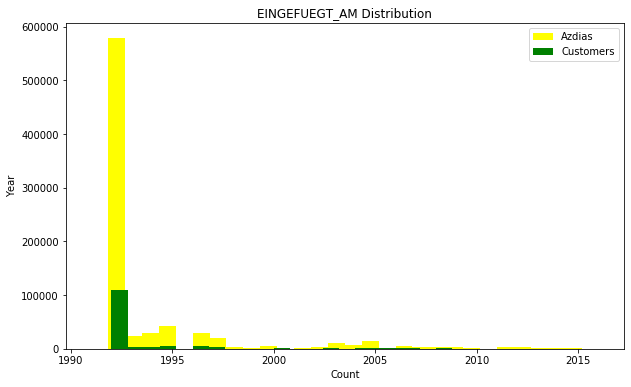

In [35]:
# plot the histogram of the 'EINGEFUEGT_AM'
plt.figure(figsize=(10,6))
plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias", color='yellow')
plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers", color='green')
plt.ylabel("Year")
plt.xlabel("Count")
plt.title("EINGEFUEGT_AM Distribution")
plt.legend()
plt.show()

From the plot, it seems like the distributions are almost similar. And the people who are registered in years before 1995 are more likely to be customers. We can further analyse and change other categorical columns after making sure all the unkown values are replaced with NaNs in the dataframes.

In [49]:
# check the unknown value
unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(len(unkown_attributes_values))

232


In [50]:
def get_unkown_repr(attrib, unkown_attributes_values):
    """Returns the representation of unkown values"""
    
    unkown = unkown_attributes_values[unkown_attributes_values["Attribute"] == attrib]["Value"]
    unkown = unkown.astype(str).str.cat(sep=",")
    unkown = [int(x) for x in unkown.split(",")]
      
    return [unkown]

In [51]:
ager_typ_unkwon = get_unkown_repr("AGER_TYP", unkown_attributes_values)
print(ager_typ_unkwon)

[[-1]]


In [52]:
def replace_unkown_with_nan(val, unkown):
    """Replaces unkown values with np.nan values if the value mathes with the unkown representation"""
    if val in unkown:
        return np.nan
    else:
        return val

In [53]:
def replace_unkowns(df, unkown_attributes_values, verbose=False):
    """
    Replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list.
    """
    for attrib in unkown_attributes_values.Attribute:
        unkown = get_unkown_repr(attrib, unkown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unkown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
    return df

In [54]:
# Replaces unkown values to 'np.nan'
azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_70
Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Repl

In [55]:
customers = replace_unkowns(customers, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_61_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_80
Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Replacing [[-1]] to NaN in Attribute KBA13_SEG_MINIVA

#### Missing values

In [56]:
def get_missing_report(df):
    """
    # Takes in a dataframe and returns a dataframe 
    # with information about column-wise 
    # missing values percentages.
    """
    missing_percen = df.isna().sum() * 100 / len(df)
    
    missing_percen_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    return missing_percen_df

In [57]:
customer_missing_report = get_missing_report(customers)
azdias_missing_report = get_missing_report(azdias)

In [48]:
print("Total Nom of columns in Customers - ", len(customers.columns))
print("Nom of columns with missing values in customers - ",
      len(customer_missing_report[customer_missing_report.Missing_Percentage > 0]))

print("Total Nom of columns in Azdias - ", len(azdias.columns))
print("Nom of columns with missing values in azdias - ",
      len(azdias_missing_report[azdias_missing_report.Missing_Percentage > 0]))

Total Nom of columns in Customers -  370
Nom of columns with missing values in customers -  280
Total Nom of columns in Azdias -  367
Nom of columns with missing values in azdias -  280


In [49]:
def plot_percentage_missing(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax=ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax=ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    plt.show()

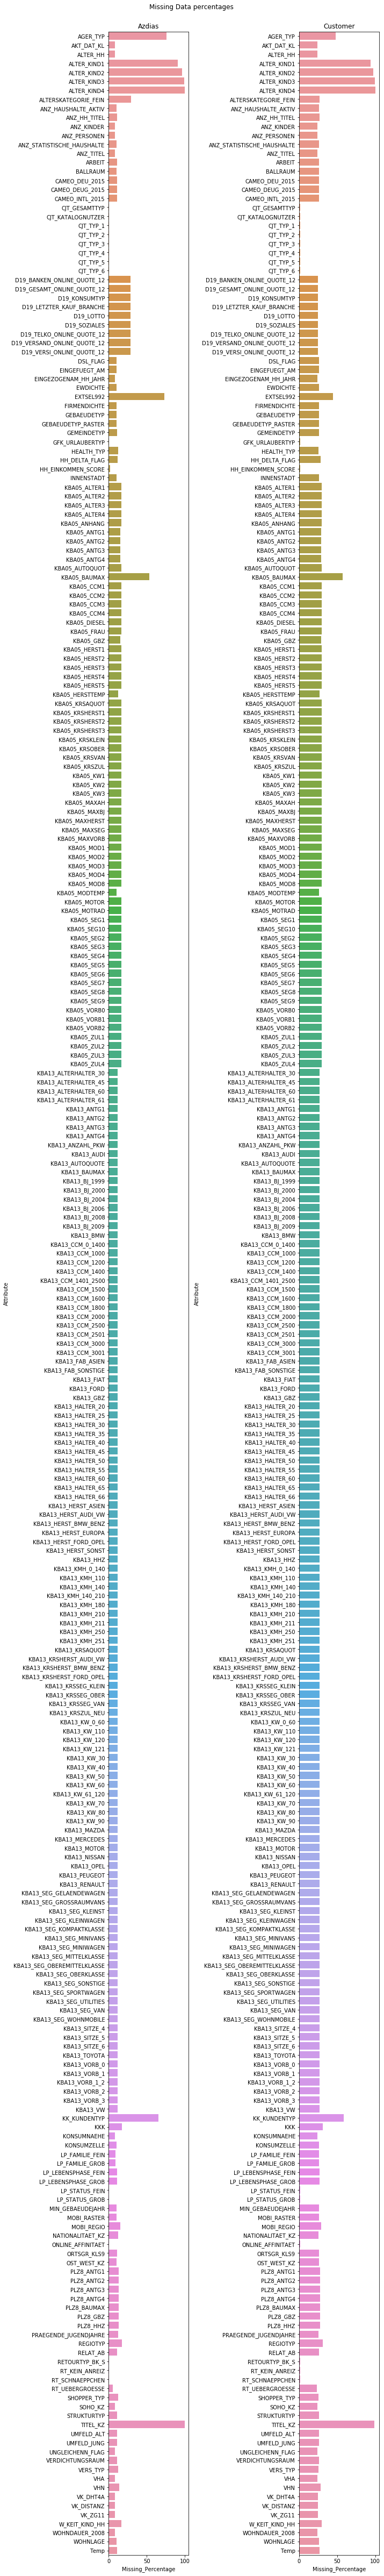

In [50]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=0)

From the plot, notice that there is overlap in both Azdias and Customers data i.e. data is missing from same columns. Also, there is some cols which contain too much NaN values that can not be considered effective features, so we can simply remove some features with some threshold. In this case, we choose 0.3 to the cutting threshold.

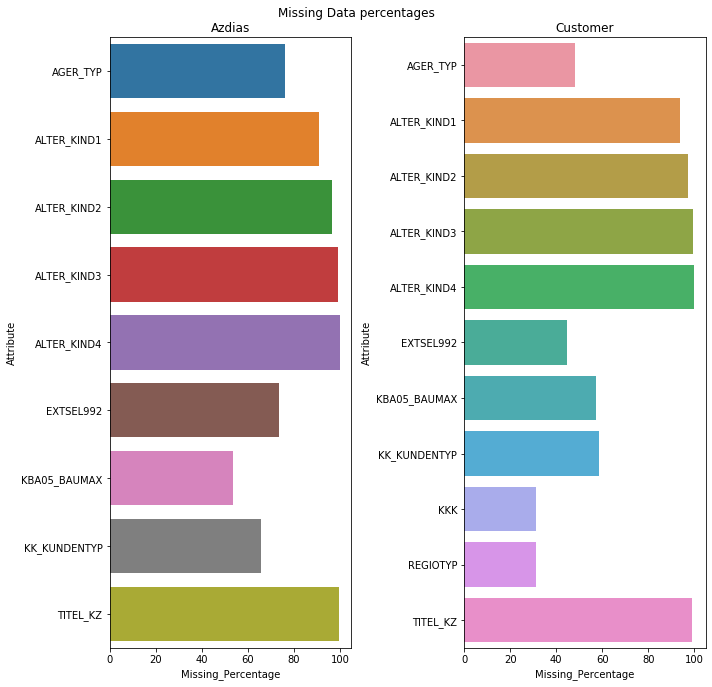

In [51]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=30, figsize=(10, 10))

In [58]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
         
    df1 = remove_columns(df1, remove_cols)
    df2 = remove_columns(df2, remove_cols)
    print(f"\t\tRemoved {len(remove_cols)} columns from given dataframes")
    
    return (df1, df2, remove_cols)

In [59]:
print("Num of columns Before dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

azdias, customers, removed_cols = remove_missing_columns(azdias, customers, 
                                                         customer_missing_report, 
                                                         azdias_missing_report)

print("Num of columns After dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Num of columns Before dropping
Azdias - 367
Customers - 370
		Removed 11 columns from given dataframes
Num of columns After dropping
Azdias - 356
Customers - 359


In [54]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

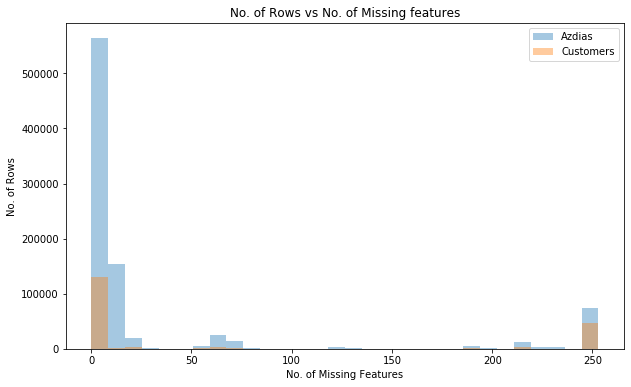

In [55]:
plot_missing_rowwise_histogram(azdias, customers)

In [60]:
def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [61]:
print("Num of rows Before dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print("Num of rows After dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

Num of rows Before dropping
Azdias - 891221
Customers - 191652
		Removed 57406 rows from  dataframe
		Removed 153933 rows from  dataframe
Num of rows After dropping
Azdias - 737288
Customers - 134246


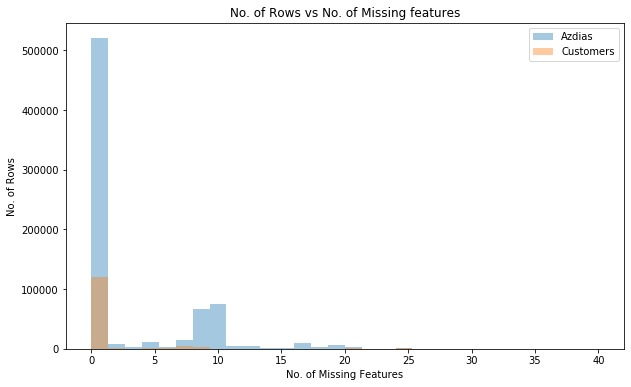

In [58]:
plot_missing_rowwise_histogram(azdias, customers)

In [62]:
# For simplicity, we can remove these cols
# as they have too much granularity in information they represent
remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", 
                     "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

azdias = remove_columns(azdias, remove_extra_cols)
customers = remove_columns(customers, remove_extra_cols)

#### Encoding the catogorical data
+ `OST_WEST_KZ column` col

In [63]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

+ `ANREDE_KZ` col

In [64]:
def fix_anrede_col(df):
    """
    Function to label encode the feature "ANREDE_KZ"
    """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

In [65]:
azdias = fix_ost_west_col(azdias)
customers = fix_ost_west_col(customers)
azdias = fix_anrede_col(azdias)
customers = fix_anrede_col(customers)

+ `CAMEO_INTL_2015` col

In [66]:
def fix_cameo_intl_col(df):
    """
    Function to label encode the feature "CAMEO_INTL_2015"
    """
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) 
                                                               if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) 
                                                               if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

In [67]:
azdias = fix_cameo_intl_col(azdias)
customers = fix_cameo_intl_col(customers)

+ `WOHNLAGE` col

In [68]:
azdias.WOHNLAGE.value_counts()

3.0    235402
7.0    161356
4.0    127406
2.0     94544
5.0     67924
1.0     41440
8.0      9199
0.0        17
Name: WOHNLAGE, dtype: int64

In [69]:
def fix_wohnlage_col(df):
    """
    Function to remove '0' from "WOHNLAGE" 
    """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    return df

In [70]:
azdias = fix_wohnlage_col(azdias)
customers = fix_wohnlage_col(customers)

In [71]:
# seperate the extra cols
customer_extra_cols = customers[extra_cols_in_customers]
customers = customers.drop(extra_cols_in_customers, axis = 1)

In [72]:
customer_extra_cols.head()

PRODUCT_GROUP CUSTOMER_GROUP  ONLINE_PURCHASE
0  COSMETIC_AND_FOOD    MULTI_BUYER                0
1  COSMETIC_AND_FOOD    MULTI_BUYER                0
2           COSMETIC    MULTI_BUYER                0
3               FOOD    MULTI_BUYER                0
4  COSMETIC_AND_FOOD    MULTI_BUYER                0

In [73]:
# check the dataset again
azdias.shape, customers.shape, customer_extra_cols.shape

((737288, 353), (134246, 353), (134246, 3))

In [74]:
customer_extra_cols.isna().sum()

PRODUCT_GROUP      0
CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
dtype: int64

In [75]:
# deal with remaining missing value with imputing method
imputer = SimpleImputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

**Now since above we have completed some parts, we save the data for efficiency**

In [73]:
azdias.to_csv('./data/Azdias_cleaned.csv', index=False)
customers.to_csv('./data/Customers_cleaned.csv', index=False)
customer_extra_cols.to_csv('./data/Customer_Additional_cleaned.csv', index=False)

In [76]:
# Column LNR corresponds to id of each person and not a feature.
azdias = azdias.drop("LNR", axis=1)
customers = customers.drop("LNR", axis=1)

**Feature Scaling**

After cleaning the data, we can now scale the data to make sure all the features have the same range. We are going to use StandardScaler from sklearn to scale the data.

In [77]:
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [76]:
azdias.head()

AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0    1.262251 -1.430675              1.560767             0.186813   
1    1.262251  0.801403              0.674377             0.120634   
2   -0.934331  0.276209             -0.212013            -0.474979   
3   -0.934331  1.195299              0.009584            -0.342620   
4   -0.934331 -0.117688             -0.876806            -0.210262   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0     -0.125303   -0.299061      0.224688                    0.335407   
1     -0.125303   -0.299061     -0.634469                   -0.031840   
2     -0.125303   -0.299061     -1.493626                   -0.399086   
3     -0.125303   -0.299061      1.943002                   -0.325637   
4     -0.125303   -0.299061     -0.634469                   -0.399086   

   ANZ_TITEL    ARBEIT  ...   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0   -0.06066 -0.183295  ...  1.454873       -0.747722        0.547826   
1   -0.06066 -0.183295  ...  0.023979       -0.747722        0.547826   
2   -0.06066 -1.187413  ...  1.812596        0.952074        0.547826   
3   -0.06066  0.820823  ... -0.691468       -1.314321        0.547826   
4   -0.06066 -1.187413  ... -0.691468        0.952074        0.547826   

   WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB      Temp  \
0 -0.028580  1.141224   0.958448             -1.682098  0.452818   
1 -1.083176  1.141224   0.958448              0.168026 -0.990800   
2  1.553315 -0.279664   0.958448              1.093087 -1.151202   
3 -0.555878  0.430780  -1.043354              0.168026  1.335028   
4  1.553315  0.430780   0.958448             -1.682098 -0.589795   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0                1.167642               -1.247569  
1               -0.877925                0.764156  
2               -1.559780               -0.576994  
3                0.485786                0.093581  
4                1.167642                0.764156  

[5 rows x 352 columns]

In [77]:
customers.head()

AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0   -0.934331 -0.117688             -0.876806            -0.474979   
1   -0.934331 -0.642882             -3.092781            -0.474979   
2   -0.934331 -0.380285             -1.320001            -0.541158   
3   -0.934331  1.195299              0.009584            -0.077904   
4   -0.934331  0.013611             -0.876806            -0.474979   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0     -0.125303   -0.299061      0.224688                   -0.472535   
1     -0.125303   -0.299061     -0.634469                   -0.472535   
2     -0.125303   -0.299061     -1.493626                   -0.472535   
3     -0.125303   -0.299061      1.943002                   -0.031840   
4     -0.125303   -0.299061      0.224688                   -0.472535   

   ANZ_TITEL    ARBEIT  ...   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0   -0.06066 -2.191531  ... -1.406915        0.952074        0.547826   
1   -0.06066 -0.183295  ...  1.812596        0.952074        0.547826   
2   -0.06066 -2.191531  ... -1.406915        0.952074        0.547826   
3   -0.06066 -0.183295  ... -0.691468       -1.314321        0.547826   
4   -0.06066 -0.183295  ... -1.764638        0.952074        0.547826   

   WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB      Temp  \
0  1.553315 -0.279664  -1.043354              1.093087  0.372617   
1 -1.083176 -0.279664   0.958448              1.093087 -0.188790   
2  1.553315 -1.700552  -1.043354              1.093087 -1.151202   
3 -0.555878 -1.700552  -1.043354              0.168026  1.254827   
4 -1.610474 -0.990108  -1.043354              0.168026  0.132014   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0               -1.559780                0.093581  
1               -0.196069                0.764156  
2               -0.877925                0.764156  
3                0.485786               -1.247569  
4               -0.196069                0.764156  

[5 rows x 352 columns]

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## 1.1 Dimensionality reduction

For dataset with many features, or feature dimensions, it is often an effective way to perform dimensionlity reduction as to increase model efficiency as well as to improve model performance. We can use a statistical approach to find how much variance is explained by each feature. One such algorithm is Principal Component Analysis(PCA).

In [78]:
def perform_pca(data, n_components=None):
    """Func to do pca
    """
    pca = PCA(n_components, random_state=SEED)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [79]:
pca_azdias, _ = perform_pca(azdias, None)

In [80]:
def plot_pca_exp_variance(pca_azdias, cumulative=True, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()

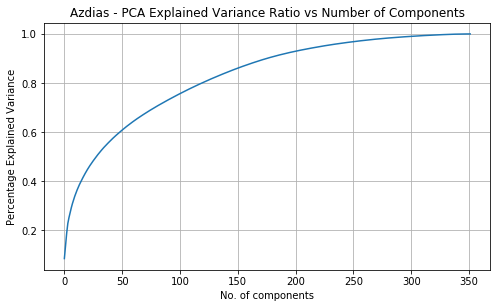

In [81]:
plot_pca_exp_variance(pca_azdias)

From the explained variance plot it is observed that around 150 components explain 90% of variance in the dataset. We can set the number of components to 150 and perform PCA analysis to have 150 compinents. Then we can see the feature importances for each component, to understand what each PCA component represents.

In [82]:
pca_150, azdias_pca_150 = perform_pca(azdias, n_components=150)

### 1.1.1 Interpreting PCA components

We can now look at the feature weights given by the PCA algorithm and understand what each component is comprised of. We can write a function to get information about the top n positive features and top n negative features for a given component.

In [83]:
def plot_feature_weights(df, pca, attributes_info, 
                         dimension, n_weights = 5, 
                         plot=True,figsize=(7,8)):
    """
    This function displays features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, 
                      "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, 
                               ascending=False, ignore_index=True)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

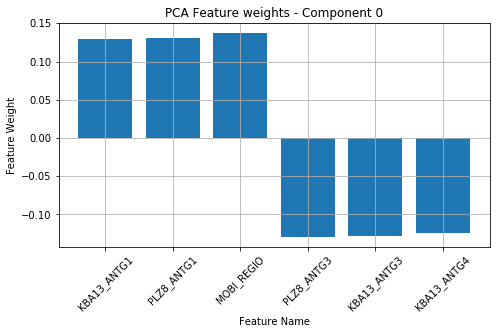

Feature                               Description  FeatureWeight
0   MOBI_REGIO                           moving patterns       0.137053
1   PLZ8_ANTG1   number of 1-2 family houses in the PLZ8       0.130411
2  KBA13_ANTG1                      No description given       0.129759
3  KBA13_ANTG4                      No description given      -0.124765
4  KBA13_ANTG3                      No description given      -0.128528
5   PLZ8_ANTG3  number of 6-10 family houses in the PLZ8      -0.129237

In [84]:
# component 0
component_0_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 0, 3)
component_0_info.head(10)

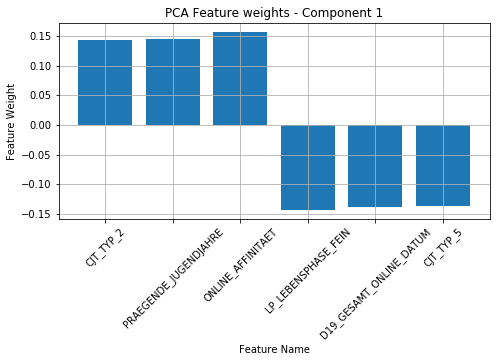

Feature                                        Description  \
0        ONLINE_AFFINITAET                                    online affinity   
1    PRAEGENDE_JUGENDJAHRE  dominating movement in the person's youth (ava...   
2                CJT_TYP_2                               No description given   
3                CJT_TYP_5                               No description given   
4  D19_GESAMT_ONLINE_DATUM  actuality of the last transaction with the com...   
5      LP_LEBENSPHASE_FEIN                                     lifestage fine   

   FeatureWeight  
0       0.156750  
1       0.145748  
2       0.142592  
3      -0.136657  
4      -0.138195  
5      -0.143904

In [85]:
# component 1
component_1_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 1, 3)
component_1_info.head(10)

In [86]:
# component 2
component_2_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 2, 3)
component_2_info.head(10)

Feature  \
0         KBA13_HERST_BMW_BENZ   
1  KBA13_SEG_OBEREMITTELKLASSE   
2               KBA13_MERCEDES   
3            KBA13_KMH_140_210   
4         KBA13_SEG_KLEINWAGEN   
5                KBA13_SITZE_5   

                                         Description  FeatureWeight  
0       share of BMW & Mercedes Benz within the PLZ8       0.183271  
1  share of upper middle class cars and upper cla...       0.158266  
2                  share of MERCEDES within the PLZ8       0.156829  
3  share of cars with max speed between 140 and 2...      -0.128896  
4  share of small and very small cars (Ford Fiest...      -0.131205  
5            number of cars with 5 seats in the PLZ8      -0.151114

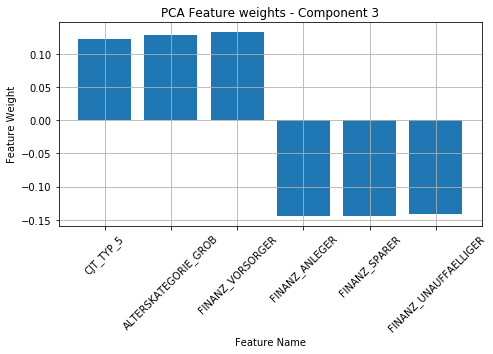

Feature                       Description  FeatureWeight
0       FINANZ_VORSORGER   financial typology: be prepared       0.133352
1   ALTERSKATEGORIE_GROB     age through prename analysis        0.127511
2              CJT_TYP_5              No description given       0.121912
3  FINANZ_UNAUFFAELLIGER  financial typology: unremarkable      -0.140980
4          FINANZ_SPARER   financial typology: money saver      -0.144219
5         FINANZ_ANLEGER      financial typology: investor      -0.144784

In [87]:
# component 3
component_3_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 3, 3)
component_3_info.head(10)

As we can see:
+ component 0: 
  + Has a high positive weight to moving patterns of people.
  + Has a high weight to number of 1-2 family houses in the neighbourhood and a negative weight to number of 6-10 family houses.
  + KBA13_* - this feature has no description given (in Attributes - levels data), but some similar features (which have a description) correspond to shares of cars with some specification.
+ component 1:
  + Has a high positive weights towards features describing online activity and transactions of last 12 and 24 months.
  + Has a negative weight to features containing information about when was the last transaction made.
+ component 2:
  + Has a high positive weights towards features that have information about upper class car's shares.
  + Has a negative weight to features that have information about lower class cars's share.
+ component 3:
  + This component corresponds to people who are always financially prepared.
  + This component has a negative weight to people who save money or invest money.
  + Also the age determined through prename analysis has a big impact on this component.
  + The movement a person witnessed/participated during their youth has a negative weight on this component.

Further investigation of new features can be down

## 1.2. Customer Segmentation - K-Means Clustering

After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.

In [88]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    """
    # Kmeans clustering on dataset, try different nums of clusters
    # to get the best clustering score
    """
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [89]:
%%time
scores, range_ = get_Kmeans_scores(azdias_pca_150, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  206732631.32693887
Time elapsed: 66.12 sec.

Training for n_clusters:  3
Done! Score:  199014330.7953785
Time elapsed: 93.29 sec.

Training for n_clusters:  4
Done! Score:  194627885.6038468
Time elapsed: 183.67 sec.

Training for n_clusters:  5
Done! Score:  190866647.86689565
Time elapsed: 208.63 sec.

Training for n_clusters:  6
Done! Score:  187973115.4954833
Time elapsed: 209.94 sec.

Training for n_clusters:  7
Done! Score:  185549809.8480994
Time elapsed: 258.53 sec.

Training for n_clusters:  8
Done! Score:  183484049.4604215
Time elapsed: 319.53 sec.

Training for n_clusters:  9
Done! Score:  181714419.98490444
Time elapsed: 287.27 sec.

Training for n_clusters:  10
Done! Score:  180357004.530538
Time elapsed: 304.09 sec.

Training for n_clusters:  11
Done! Score:  179105052.31764713
Time elapsed: 417.52 sec.

Training for n_clusters:  12
Done! Score:  178000317.0964399
T

In [90]:
def plot_elbow(scores, range_):
    """Plot to see the score-cluster result
    """
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "*", color="blue")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

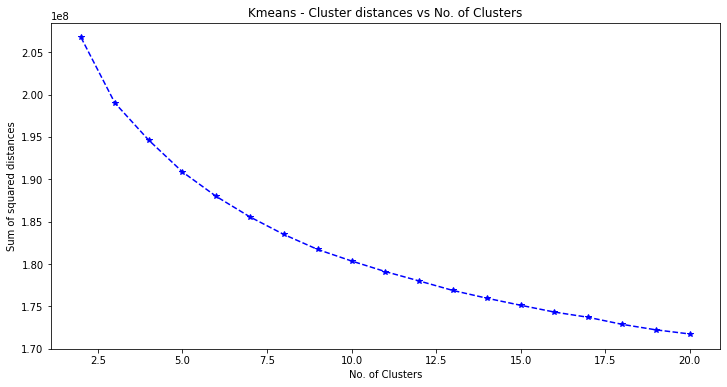

In [91]:
plot_elbow(scores, range_)

#### Choosing Number of Clusters

The basic idea behind clustering algorithms is to select the number of clusters so as to  minimize the intra-cluster variation.  In this process the elbow method is chosen to select the optimal number of clusters.  [Alboukadel Kassambara](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/)

From the elbow above, we can see that the sum of sqaured error decreasing with a high slope until around **8 clusters** and then the slope decreases. 

In [92]:
kmeans = KMeans(8, random_state=SEED)

kmeans.fit(azdias_pca_150)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [93]:
azdias_clusters = kmeans.predict(azdias_pca_150)

In [94]:
customers_pca_150 = pca_150.transform(customers)

In [95]:
customers_clusters = kmeans.predict(customers_pca_150)

In [96]:
print(azdias_clusters[:15], "\n",customers_clusters[:15])

[5 5 3 1 3 5 5 4 4 7 5 5 4 6 5] 
 [3 7 3 1 4 0 4 7 0 0 0 7 4 0 0]


In [97]:
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [98]:
customers_clusters.value_counts().sort_index()

0    36828
1     4336
2     3419
3    40247
4    29743
5     1312
6     2147
7    16214
dtype: int64

In [99]:
azdias_clusters.value_counts().sort_index()

0    116152
1     64979
2     69671
3    116769
4     69076
5    112546
6     89379
7     98716
dtype: int64

In [100]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

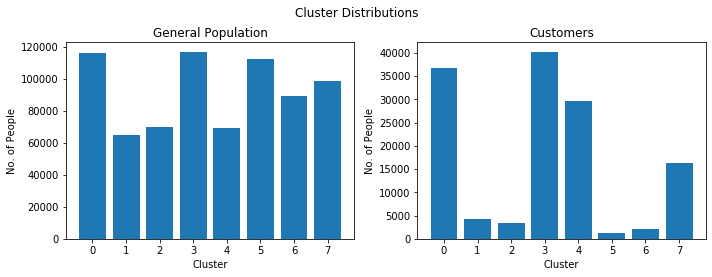

In [101]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Also, we would like to know that:

*How much percentage of population under consideration is present in each cluster?*

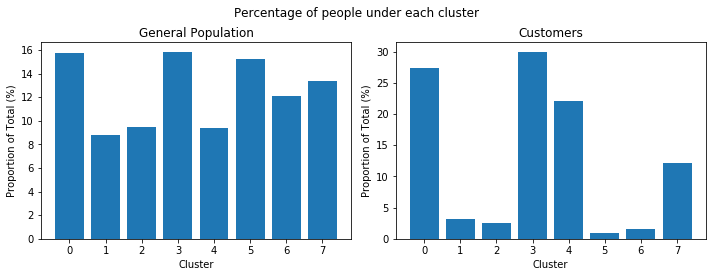

In [102]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Pop_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Cust_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

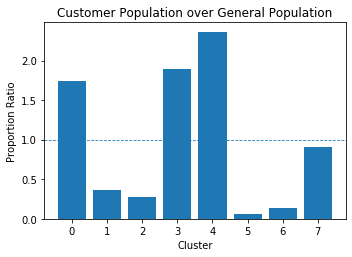

In [103]:
# Ratio of Proportion of Customers to Proportion of General Population in each cluster
cluster_info["Cust_over_Pop"] = cluster_info["Cust_proportion"] / cluster_info["Pop_proportion"]
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(cluster_info["Cluster"], cluster_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [104]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, 
                    attributes_info, num_components=2, num_feat_per_comp=3):
    """
    # show which pca component influences a given cluster most 
    # then identifying which feature influences that pca component
    """
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True, ignore_index=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [105]:
cluster_0 = explain_cluster(kmeans, 0, azdias, pca_150, attributes_info)
cluster_0

Component  ComponentWeight                  Feature  \
0           0         7.619460               MOBI_REGIO   
1           0         7.619460               PLZ8_ANTG1   
2           0         7.619460              KBA13_ANTG1   
3           0         7.619460              KBA13_ANTG4   
4           0         7.619460              KBA13_ANTG3   
5           0         7.619460               PLZ8_ANTG3   
6           1         3.421127        ONLINE_AFFINITAET   
7           1         3.421127    PRAEGENDE_JUGENDJAHRE   
8           1         3.421127                CJT_TYP_2   
9           1         3.421127                CJT_TYP_5   
10          1         3.421127  D19_GESAMT_ONLINE_DATUM   
11          1         3.421127      LP_LEBENSPHASE_FEIN   

                                          Description  FeatureWeight  
0                                     moving patterns       0.137053  
1             number of 1-2 family houses in the PLZ8       0.130411  
2                                No description given       0.129759  
3                                No description given      -0.124765  
4                                No description given      -0.128528  
5            number of 6-10 family houses in the PLZ8      -0.129237  
6                                     online affinity       0.156750  
7   dominating movement in the person's youth (ava...       0.145748  
8                                No description given       0.142592  
9                                No description given      -0.136657  
10  actuality of the last transaction with the com...      -0.138195  
11                                     lifestage fine      -0.143904

In [106]:
cluster_3 = explain_cluster(kmeans, 3, azdias, pca_150, attributes_info)
cluster_3

Component  ComponentWeight               Feature  \
0           0         3.697958            MOBI_REGIO   
1           0         3.697958            PLZ8_ANTG1   
2           0         3.697958           KBA13_ANTG1   
3           0         3.697958           KBA13_ANTG4   
4           0         3.697958           KBA13_ANTG3   
5           0         3.697958            PLZ8_ANTG3   
6           9         0.440057  KBA13_ALTERHALTER_45   
7           9         0.440057       KBA13_HALTER_40   
8           9         0.440057     KBA13_KMH_140_210   
9           9         0.440057             KBA13_HHZ   
10          9         0.440057              PLZ8_HHZ   
11          9         0.440057      KBA13_ANZAHL_PKW   

                                          Description  FeatureWeight  
0                                     moving patterns       0.137053  
1             number of 1-2 family houses in the PLZ8       0.130411  
2                                No description given       0.129759  
3                                No description given      -0.124765  
4                                No description given      -0.128528  
5            number of 6-10 family houses in the PLZ8      -0.129237  
6   share of car owners between 31 and 45 within t...       0.165154  
7   share of car owners between 36 and 40 within t...       0.161650  
8   share of cars with max speed between 140 and 2...       0.160807  
9                                No description given      -0.151189  
10               number of households within the PLZ8      -0.151749  
11                         number of cars in the PLZ8      -0.179410

In [107]:
cluster_7 = explain_cluster(kmeans, 7, azdias, pca_150, attributes_info)
cluster_7

Component  ComponentWeight                Feature  \
0           3         2.197477       FINANZ_VORSORGER   
1           3         2.197477   ALTERSKATEGORIE_GROB   
2           3         2.197477              CJT_TYP_5   
3           3         2.197477  FINANZ_UNAUFFAELLIGER   
4           3         2.197477          FINANZ_SPARER   
5           3         2.197477         FINANZ_ANLEGER   
6           8         1.207605   KBA13_ALTERHALTER_61   
7           8         1.207605        KBA13_HALTER_65   
8           8         1.207605        KBA13_HALTER_66   
9           8         1.207605   KBA13_ALTERHALTER_45   
10          8         1.207605     KBA13_FAB_SONSTIGE   
11          8         1.207605      KBA13_HERST_SONST   

                                          Description  FeatureWeight  
0                     financial typology: be prepared       0.133352  
1                       age through prename analysis        0.127511  
2                                No description given       0.121912  
3                    financial typology: unremarkable      -0.140980  
4                     financial typology: money saver      -0.144219  
5                        financial typology: investor      -0.144784  
6   share of car owners elder than 60 within the PLZ8       0.171870  
7   share of car owners between 61 and 65 within t...       0.159775  
8         share of car owners over 66 within the PLZ8       0.157783  
9   share of car owners between 31 and 45 within t...      -0.137425  
10       share of other Manufacturers within the PLZ8      -0.154408  
11                share of other cars within the PLZ8      -0.154408

* From the above printed dataframes, we can conclude what kind of people constitute in each cluster. And what characteristics correspond to each cluster can also be understood at a greater detail.

* This analysis helps in understanding the existing customers and their behaviour according to demographics and other data collected.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv')

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
mailout_train.shape

(42962, 368)

In [110]:
mailout_train.head()

Unnamed: 0   LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0           0  1763         2         1.0       8.0          NaN          NaN   
1           1  1771         1         4.0      13.0          NaN          NaN   
2           2  1776         1         1.0       9.0          NaN          NaN   
3           3  1460         2         1.0       6.0          NaN          NaN   
4           4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ...  VK_DHT4A  VK_DISTANZ  \
0          NaN          NaN                   8.0  ...       5.0         2.0   
1          NaN          NaN                  13.0  ...       1.0         2.0   
2          NaN          NaN                   7.0  ...       6.0         4.0   
3          NaN          NaN                   6.0  ...       8.0        11.0   
4          NaN          NaN                   9.0  ...       2.0         2.0   

   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  RESPONSE  \
0      1.0             6.0             9.0       3.0         3         0   
1      1.0             4.0             9.0       7.0         1         0   
2      2.0             NaN             9.0       2.0         3         0   
3     11.0             6.0             9.0       1.0         3         0   
4      1.0             6.0             9.0       3.0         3         0   

  ANREDE_KZ ALTERSKATEGORIE_GROB  
0         2                    4  
1         2                    3  
2         1                    4  
3         2                    4  
4         1                    3  

[5 rows x 368 columns]

0    42430
1      532
Name: RESPONSE, dtype: int64


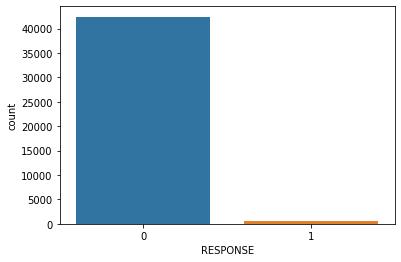

In [111]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

### 2.1. Selecting the Evaluation Metric

From the above plot, we can see that the data is highly imbalanced. We have more thn 40 thousand - `0` responses and only 532 - `1` responses. Accuracy will be a bad metric to choose for this problem since the accuracy might always be more than 98% even if the model predicts all zeros.

To address this imbalance while evaluating the model we need to chose a metric which will take this class imbalance into accounts. The usual metrics used for imbalanced classification are *Precision and Recall* or *Area under Receiver Operating Curve (AUROC)*. 

* Confusion Matrix: is a `2x2` matrix in case of binary classification problems which shows the number of values predicted correctly and the number of values predicted wrongly. The confusion matrix is the base for any classification metric, even accuracy can be calculated from the values inside confusion matrix.

Terms inside confusion matrix:
* **True Positives (TP)** - Number of positive observations predicted as positive
* **True Negatives (TN)** - Number of negative observations predicted as negative
* **False Negatives (FN)** - Number of positive observations predicted as negative
* **False Positives (FP)** - Number of negative observations predicted as positive


**Precision and Recall**:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)

**ROC curve**
* True Positive Rate = TP / (TP + FN)
* False Positive Rate = FP / (FP + TN)

For this problem, we need to be able to tell whether a person will be a future possible customer. AUROC metric which considers both true positive rate and false positive rate seem to be a good choice for this problem, since we want to be able to correctly predict both cases i.e. whether a person becomes a customer or not. Since, Both these predictions are important for us.


### 2.2. Cleaning data for Modelling

Before trying out different models, we should also preprocess the data given here. We will follow the same cleaning steps we performed for the customers and general population data here.

In [3]:
def clean_data_for_supervised(cleaned_azdias, df, attributes_values):
    
    print("Cleaning Given Dataframe")
    
    start = time.time()
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])
        
    # Ignore if these cols are already cleaned 
    if not (df[warning_cols[0]].dtype == 'float64') & (df[warning_cols[1]].dtype == 'float64'):
        df = fix_cameo_cols(df)
        
        
    print("\tFixing LP_* columns")
    df = fix_LP_cols(df)
    
    print("\tFixing EINGEFUGT column")
    df = fix_eigefugt_col(df)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
    
    df = replace_unkowns(df, unkown_attributes_values, verbose=False)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    df = fix_ost_west_col(df)

    print("\tEncoding ANREDE Column")
    df = fix_anrede_col(df)
    
    print("\tEncoding CAMEO_INT column")
    df = fix_cameo_intl_col(df)
    
    print("\tEncoding WOHNLAGE column")
    df = fix_wohnlage_col(df)
    
    
    # Dropping columns which are not in azdias
    print("\tDropping extra columns")
    cols_to_drop = [col for col in df.columns if col not in azdias.columns]
#     cols_to_drop += ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]
    
    df = remove_columns(df, cols_to_drop)
    
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")
    
    imputer.fit(azdias)
    df = pd.DataFrame(imputer.transform(df), columns = df.columns)
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return df

In [4]:
labels = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

In [78]:
mailout_train = clean_data_for_supervised(azdias, mailout_train, attributes_values)

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding OST_WEST_KZ column
	Encoding ANREDE Column
	Encoding CAMEO_INT column
	Encoding WOHNLAGE column
	Dropping extra columns
	Imputing missing values with most frequent ones
Completed Cleaning in 13.576245069503784 seconds


In [79]:
mailout_train.shape

(42962, 352)

In [80]:
azdias.shape

(737288, 352)

### 2.3. Setting the benchmark

Training a Logistic regression model on unscaled data to set a benchmark performance that we aim to improve upon.

In [81]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [118]:
lr = LogisticRegression(random_state=SEED)

In [119]:
lr.fit(X_train, y_train)
pred = lr.predict_proba(X_val)[:,1]
print("Baseline AUROC - ", roc_auc_score(y_val, pred))

Baseline AUROC -  0.6377422962088523


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The baseline score we achieved with unscaled data with logistic regression is 0.63.

Now, we are going to try different models and tr to improve upon this score.

### 2.4. Trying out different models

#### Scaling data

In [82]:
scaler = StandardScaler()

mailout_train = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

In [83]:
# split data into train/test data
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2, random_state=SEED)

In [122]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed    

In [127]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
          ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
          ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
          ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]

In [128]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [129]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

Model AUCROC_score Time_in_sec
0      LogisticRegression      0.63506     1.29161
1  RandomForestClassifier     0.648505     8.37669
2      AdaBoostClassifier     0.699131     11.2156
3           XGBClassifier     0.686636     7.38187

Before starting hyper parameter tuning, we can also try reducing number of dimensions to see whether that helps to improve performance.

In [130]:
mailout_train_reduced = pca_150.transform(mailout_train)

X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(mailout_train_reduced, labels,
                                                                  stratify=labels, test_size=0.2, random_state=SEED)

In [132]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=SEED))]
results_reduced = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train_red, y_train_red, X_val_red, y_val_red)
    results_reduced["Model"].append(name)
    results_reduced["AUCROC_score"].append(roc)
    results_reduced["Time_in_sec"].append(time_)
    
results_reduced = pd.DataFrame.from_dict(results_reduced, orient='index').transpose()
results_reduced

Model AUCROC_score Time_in_sec
0      LogisticRegression     0.620155    0.310916
1  RandomForestClassifier     0.531418     60.4663
2      AdaBoostClassifier      0.56128     26.1534
3           XGBClassifier      0.54228     10.0104

The dimensionality reduction seems to not help here.

### 2.5 Grid Search 

#### AdaBoostClassifier

In [133]:
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.7,1.],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=SEED), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [134]:
%%time
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.1min finished


Best Score:  0.7729822723526281
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
Wall time: 7min 29s


In [135]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7431


In [91]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})') 

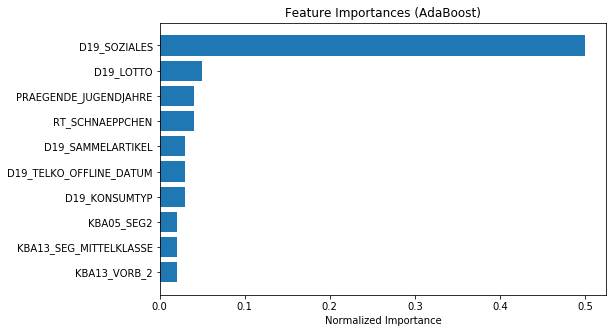

In [137]:
plot_feature_importances(model=best_adaboost, model_name="AdaBoost", feature_names=mailout_train.columns)

#### XGBoost

In [85]:
xgb_param_grid = {"max_depth": [4, 5],
              "learning_rate": [0.005, 0.01],
              "gamma":[0.5,1.0],
              "n_estimators":[100,200]
              }

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                            n_jobs=-1, eval_metric="auc",
                                                            silent=1,random_state=SEED), 
                           param_grid = xgb_param_grid, 
                           scoring = "roc_auc",
                           cv = 5, n_jobs = 8, verbose=2)

In [163]:
%%time
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:  8.6min finished


[00:48:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 8min 46s


In [164]:
print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

Best Score:  0.7772847862137995
Best Params:  {'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


In [165]:
preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

ROC score on validation data: 0.7478


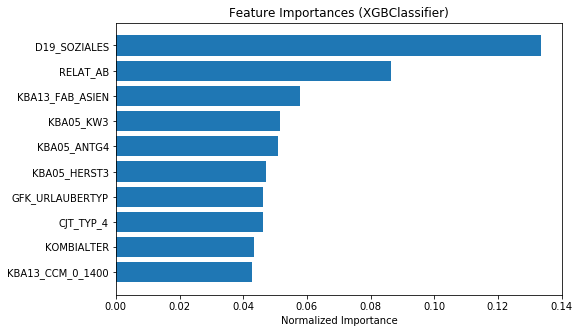

In [159]:
plot_feature_importances(model=best_xgb, model_name="XGBClassifier", feature_names=mailout_train.columns)

since the dataset is highly imbalanced, we can also try some statistical methods to improve the model, i.e. oversampling/under sampling. These methods have same effect as the weighting samples do. In this case, we try oversampling method. Also, since the data is categorical, we will use **Random Oversampling**.

#### Oversampling

In [84]:
ros = RandomOverSampler(random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [86]:
xgb_param_grid = {"max_depth": [4, 5],
              "learning_rate": [0.005, 0.01],
              "gamma":[0.5,1.0],
              "n_estimators":[100,200]
              }

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                            n_jobs=-1, eval_metric="auc",
                                                            silent=1,random_state=SEED), 
                           param_grid = xgb_param_grid, 
                           scoring = "roc_auc",
                           cv = 5, n_jobs = 8, verbose=2)

In [87]:
%%time
xgb_grid.fit(X_resampled, y_resampled)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 15.9min finished


[21:34:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 16min 13s


In [88]:
print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

Best Score:  0.8982068057529494
Best Params:  {'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


In [89]:
preds_xgb = best_xgb.predict_proba(X_val)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_xgb)))

ROC score on validation data: 0.7382


In [92]:
plot_feature_importances(model=best_xgb, model_name="XGBClassifier", feature_names=mailout_train.columns)

The oversampling method seems to be helpful, which increases the best score, and we will utilized this result on the test dataset.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [94]:
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv')

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [95]:
mailout_test_LNR = mailout_test["LNR"]
mailout_test = clean_data_for_supervised(azdias, mailout_test, attributes_values)
mailout_test = pd.DataFrame(scaler.transform(mailout_test), columns = mailout_test.columns)

Cleaning Given Dataframe
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding OST_WEST_KZ column
	Encoding ANREDE Column
	Encoding CAMEO_INT column
	Encoding WOHNLAGE column
	Dropping extra columns
	Imputing missing values with most frequent ones
Completed Cleaning in 13.78138518333435 seconds


In [150]:
# AdaBoost
best_adaboost.fit(mailout_train, labels)
preds_test_adaboost = best_adaboost.predict_proba(mailout_test)[:,1]
kaggle_adaboost = pd.DataFrame(index=mailout_test_LNR, data=preds_test_adaboost)
kaggle_adaboost.rename(columns={0: "RESPONSE"}, inplace=True)

In [151]:
kaggle_adaboost.head()

RESPONSE
LNR           
1754  0.416892
1770  0.416078
1465  0.367276
1470  0.368871
1478  0.368789

In [152]:
kaggle_adaboost.to_csv("./Submissions/submission1.csv")

In [96]:
# XGBoost
best_xgb.fit(mailout_train, labels)
preds_test_xgb = best_xgb.predict_proba(mailout_test)[:,1]
kaggle_xgb = pd.DataFrame(index=mailout_test_LNR, data=preds_test_xgb)
kaggle_xgb.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_xgb.head()

[21:37:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RESPONSE
LNR           
1754  0.094886
1770  0.091891
1465  0.070089
1470  0.070089
1478  0.070089

In [97]:
kaggle_xgb.to_csv("./Submissions/submission4.csv")